In [1]:
import pandas as pd
import numpy as np
import os
from subprocess import call

import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')
%config InlineBackend.figure_format = 'retina' # retina display

# Post-Process and Sanity Checks
---

This notebook propose a systematic analysis of the DA data obtained during the tracking studies as well as some necessary sanity checks (tune and chromaticity mainly). 

Depending on the purpose of your study, you might want to obtain a scan plot, an angle plot, or even both. This notebook presents all the different possibilities, feel free to simply adapt the scripts to your exact needs. 


NB: this notebook is assumed to be located in your *sixjobs* folder. 

---
## 1 - Read DA Data and storage
---

After running the SixDB script making the data readable, all the useful data you need should be stored under the *DA_out* folder. Let's read those files and store the data in a pandas DataFrame.

In [5]:
# The main objective is to read the DA files and to store the results in a nice DF

myFolder = 'DA_out'
myFilesNames = os.listdir(myFolder)

myFiles = [myFolder+'/'+e for e in myFilesNames]

with open(myFiles[0]) as f:
    content = f.readlines()
content = [x.strip() for x in content]

# looking for the angles 
angles = []
for n in content:
    if n[:5]=='Angle':
        angles.append(float(n[-5:]))

# initiate DF

myDF = pd.DataFrame(index=myFiles,columns=angles)

# Read files and fill the DF

for i in myFiles:
    with open(i) as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    DA_min = []
    for n in content:
        if n[:7]=='Minimum':
            DA_min.append(float(n[10:14]))
    if len(DA_min) == len(angles):
        myDF.loc[i] = DA_min
    else:
        myDF.loc[i]=np.nan

# add a column with the minimum

myDF['Min'] = myDF.min(axis=1)

---
## 2 - Scan Plot
---

In [41]:
# Here's the scan definition 

X = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]
Y = [5, 5.25, 5.5, 5.75, 6, 6.25, 6.5, 6.75, 7, 7.25, 7.5, 7.75, 8]

# Create the mesh DF

plotDF = pd.DataFrame(index=d,columns=IW)

for current in X:
    myList = []
    for distance in Y:
        index = 'DA_out/lhc2018_ats_'+str(current)+'_'+str(distance)+'.txt'
        myList.append(myDF.loc[index]['Min'])
    plotDF[current] = myList

DA_0 = plotDF[0].values[0]
deltaDF = plotDF - DA_0
xx,yy = np.meshgrid(X,Y)
zz = deltaDF.values

/afs/cern.ch/work/a/apoyet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  


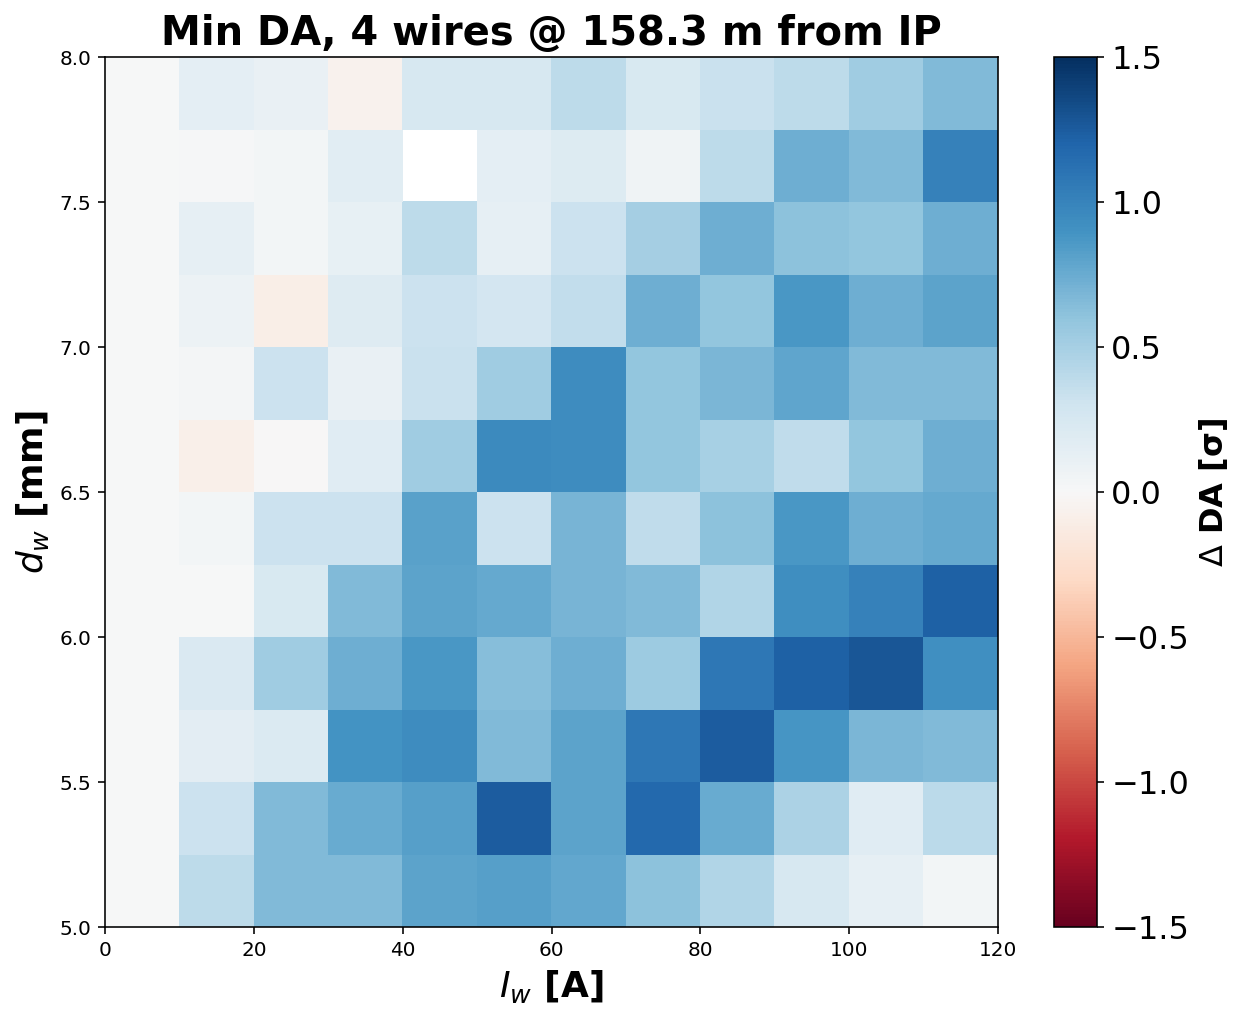

In [42]:
# Finally plot

myTitle = "Min DA, 4 wires @ 158.3 m from IP"
fig = plt.figure("scan2", figsize=(10,8))
ax  = fig.add_subplot(111)
ax.set_title(myTitle, fontsize=20, fontweight='bold')
ax.set_ylabel("$d_w$ [mm]", fontsize=18, fontweight='bold')
ax.set_xlabel("$I_w$ [A]", fontsize=18, fontweight='bold')
cf = plt.pcolormesh(xx,yy,zz, cmap=plt.cm.RdBu)
minDA = -1.5
maxDA = 1.5
#plt.plot(105,5.7,'r^',lw=4)
plt.clim(minDA, maxDA)
cbar = plt.colorbar(cf, ticks=np.linspace(minDA, maxDA, (maxDA-minDA)*2.+1))
cbar.set_label('$\\Delta$ DA [$\mathbf{\sigma}$]', rotation=90, fontsize=16, fontweight='bold')
cbar.ax.tick_params(labelsize=16)

---
## 3 - Angle Plot
---


In [18]:
def plotIsoDA(fig,R):
    x = np.linspace(0,R,100)
    y = np.linspace(0,R,100)
    fig.plot(x,np.sqrt(R**2-y**2),'k--',alpha=0.2)

In [28]:
# For this plot, you might want to select only some studies

myFilesNames = ['lhc2018_ats_0_5.25.txt','lhc2018_ats_100_5.75.txt']
myFiles = [myFolder+'/'+e for e in myFilesNames]

# filter the DF

myAngleDF = myDF.loc[myFiles].copy().drop(['Min'],axis=1)



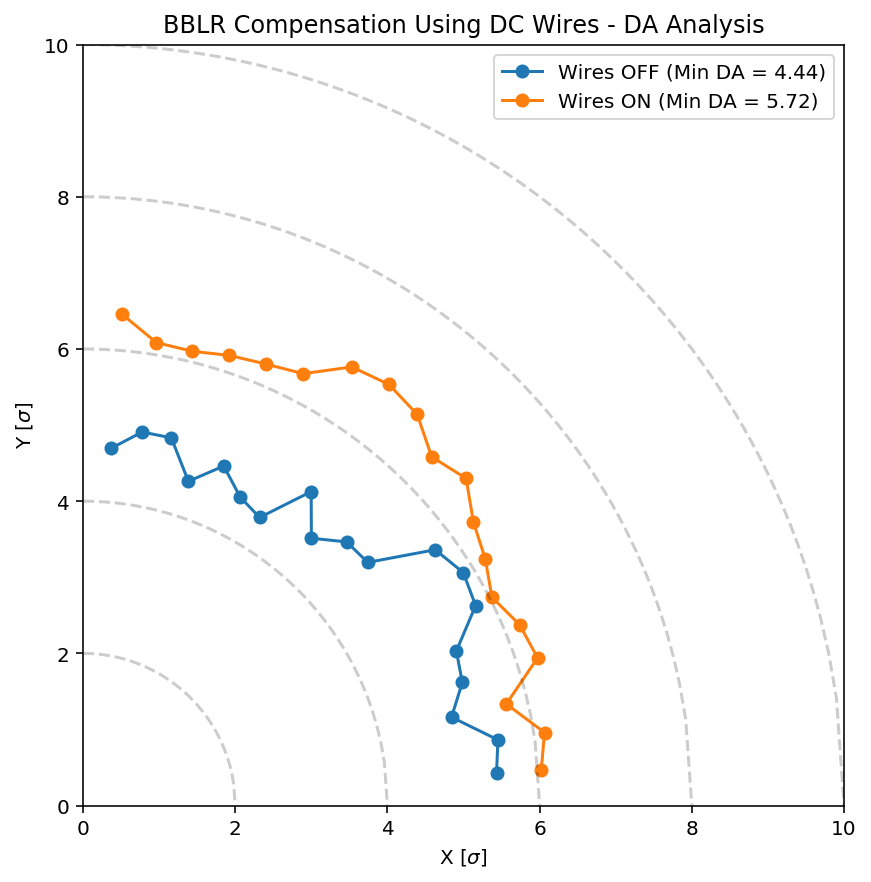

In [30]:
fig = plt.figure(figsize=(7,7))
state = ['OFF', 'ON']
count = 0
angles_rad = np.array(angles)*2*np.pi/360.
for i in myFiles:
    DA = myAngleDF.loc[i].values
    x = DA*np.cos(angles_rad)
    y = DA*np.sin(angles_rad)
    plt.plot(x,y,'o-',label='Wires '+state[count]+' (Min DA = {})'.format(np.min(DA)))
    count=count+1
plt.axis('square')
plt.xlim(0,10)
plt.ylim(0,10)
plt.xlabel('X [$\\sigma$]')
plt.ylabel('Y [$\\sigma$]')

for R in [2,4,6,8,10]:
    plotIsoDA(plt.gca(),R)

plt.legend(loc='best',frameon=True)
plt.title('BBLR Compensation Using DC Wires - DA Analysis');

---
## 4 - Sanity checks
---

In order to be comparable, one has to make that every point of the scan is obtained with the same tune and chroma. 

In [53]:
# We will need the different paths

myAbsoluteWorkPath = '/afs/cern.ch/work/a/apoyet/'
myWorkSpace = 'LHC_OPTIMAL'
myStudy = 'invert_sign'
myTemplate = 'lhc2018_ats_'

myPathInput = myAbsoluteWorkPath+myWorkSpace+'/scratch0/sixtrack_input/'+myStudy

# In general, tunes and chroma are written in this file

myFileName = 'fort.3.aux'

# Read data

QF = []
QD = []
SXF = []
SXD = []
for x in X:
    for y in Y:
        myFile = myPathInput+'/'+myTemplate+str(x)+'_'+str(y)+'/'+myFileName
        with open(myFile) as f:
            content = f.readlines()
        content = [xl.strip() for xl in content]
        for i in content:
            if(i[:2]=='QF'):
                QF.append(float(i[7:]))
            if(i[:2]=='QD'):
                QD.append(float(i[7:]))
            if(i[:3]=='SXF'):
                SXF.append(float(i[8:]))
            if(i[:3]=='SXD'):
                SXD.append(float(i[8:]))

### Tunes

######### QF #########
Max Delta = 9.43080043854e-05
Min Delta = 0.0
Mean Delta = 2.16504304917e-05


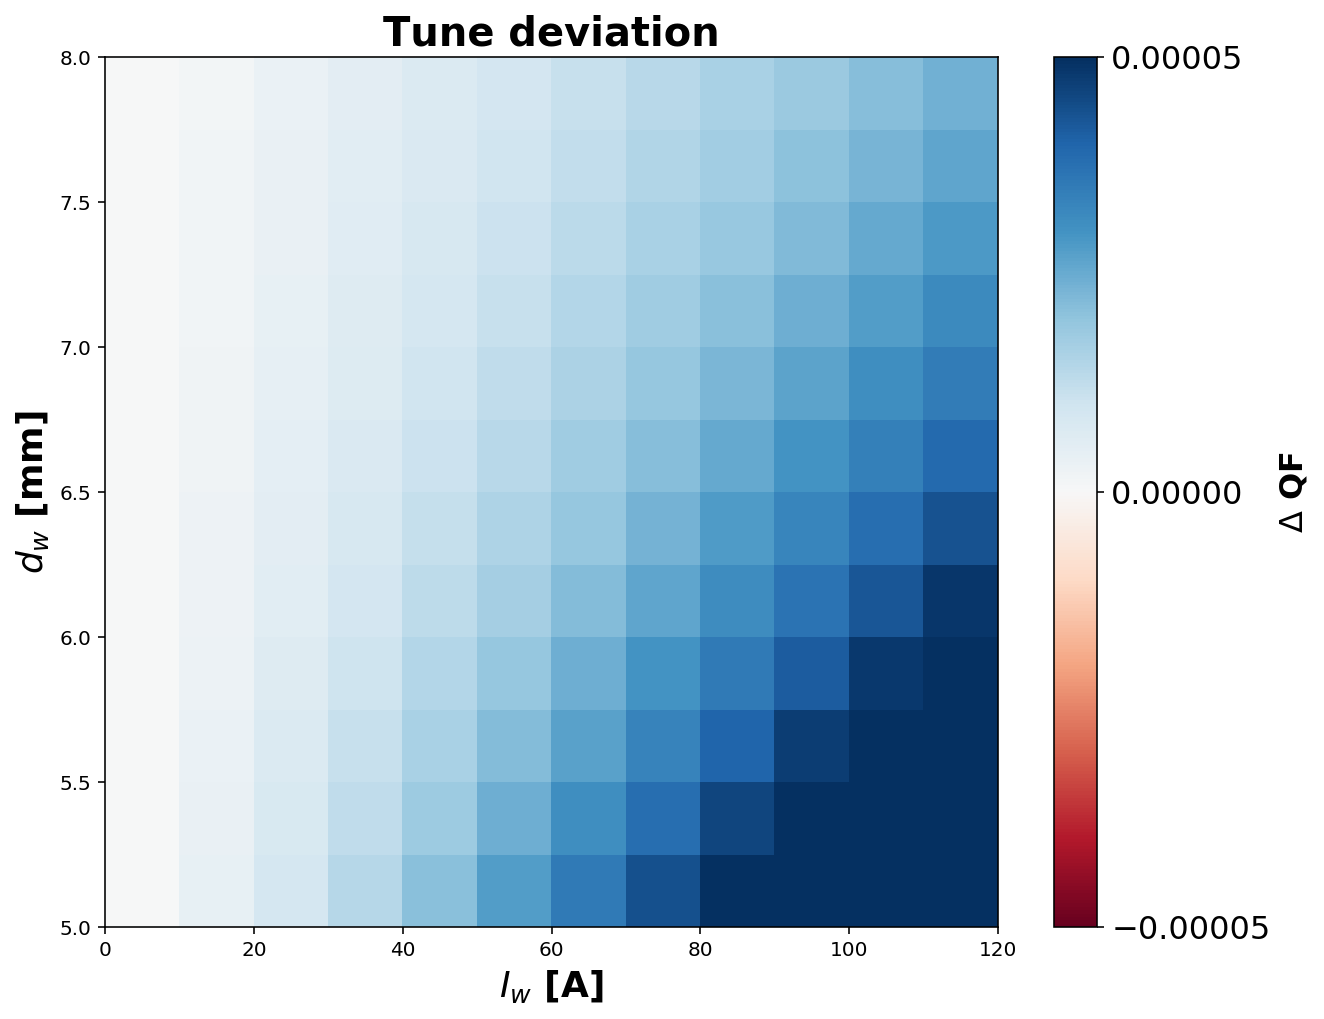

In [55]:
# QF

QF0 = QF[0]
QF_matrix = np.reshape(QF,(len(IW),len(d))) - QF0

xx,yy = np.meshgrid(IW,d)
zz =np.transpose(QF_matrix)

fig = plt.figure("scan2", figsize=(10,8))
ax  = fig.add_subplot(111)
ax.set_title("Tune deviation", fontsize=20, fontweight='bold')
ax.set_ylabel("$d_w$ [mm]", fontsize=18, fontweight='bold')
ax.set_xlabel("$I_w$ [A]", fontsize=18, fontweight='bold')
cf = plt.pcolormesh(xx,yy,zz, cmap=plt.cm.RdBu)
minDQ = -5e-5
maxDQ = 5e-5
plt.clim(minDQ, maxDQ)
cbar = plt.colorbar(cf, ticks=np.linspace(minDQ, maxDQ, 3))
cbar.set_label('$\\Delta$ QF', rotation=90, fontsize=16, fontweight='bold')
cbar.ax.tick_params(labelsize=16)

print('######### QF #########')
print('Max Delta = {}'.format(np.max(zz)))
print('Min Delta = {}'.format(np.min(zz)))
print('Mean Delta = {}'.format(np.mean(zz)))

######### QD #########
Max Delta = 4.07848835451e-05
Min Delta = 0.0
Mean Delta = 1.03915119469e-05


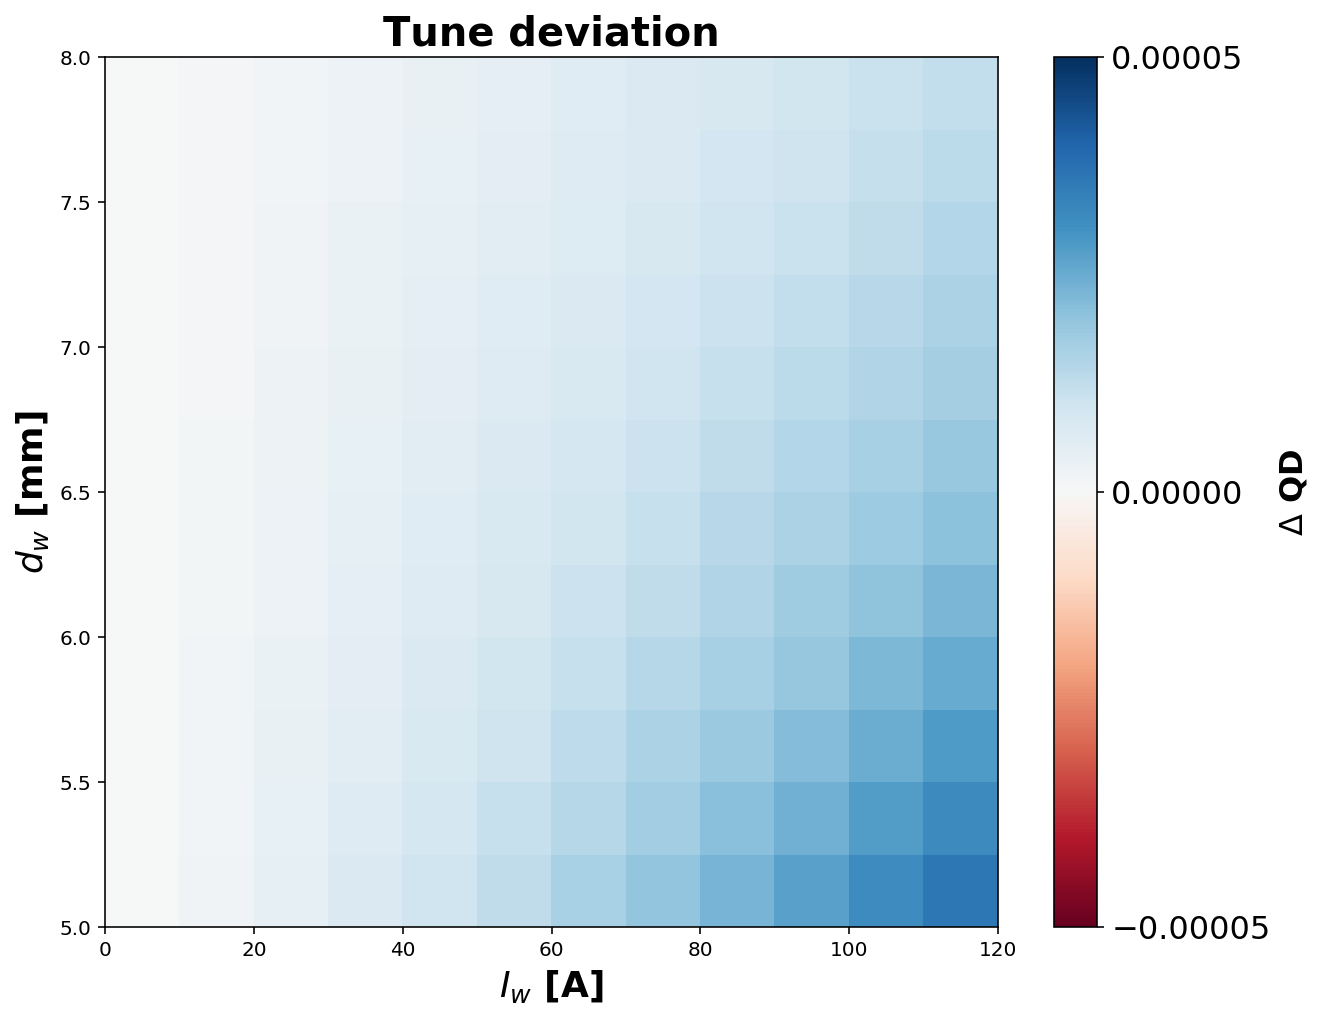

In [56]:
# QD

QD0 = QD[0]
QD_matrix = np.reshape(QD,(len(IW),len(d))) - QD0

xx,yy = np.meshgrid(IW,d)
zz =np.transpose(QD_matrix)

fig = plt.figure("scan2", figsize=(10,8))
ax  = fig.add_subplot(111)
ax.set_title("Tune deviation", fontsize=20, fontweight='bold')
ax.set_ylabel("$d_w$ [mm]", fontsize=18, fontweight='bold')
ax.set_xlabel("$I_w$ [A]", fontsize=18, fontweight='bold')
cf = plt.pcolormesh(xx,yy,zz, cmap=plt.cm.RdBu)
minDQ = -5e-5
maxDQ = 5e-5
plt.clim(minDQ, maxDQ)
cbar = plt.colorbar(cf, ticks=np.linspace(minDQ, maxDQ, 3))
cbar.set_label('$\\Delta$ QD', rotation=90, fontsize=16, fontweight='bold')
cbar.ax.tick_params(labelsize=16)

print('######### QD #########')
print('Max Delta = {}'.format(np.max(zz)))
print('Min Delta = {}'.format(np.min(zz)))
print('Mean Delta = {}'.format(np.mean(zz)))

######### SXF #########
Max Delta = 0.0
Min Delta = -2.92725701731
Mean Delta = -0.893453607726


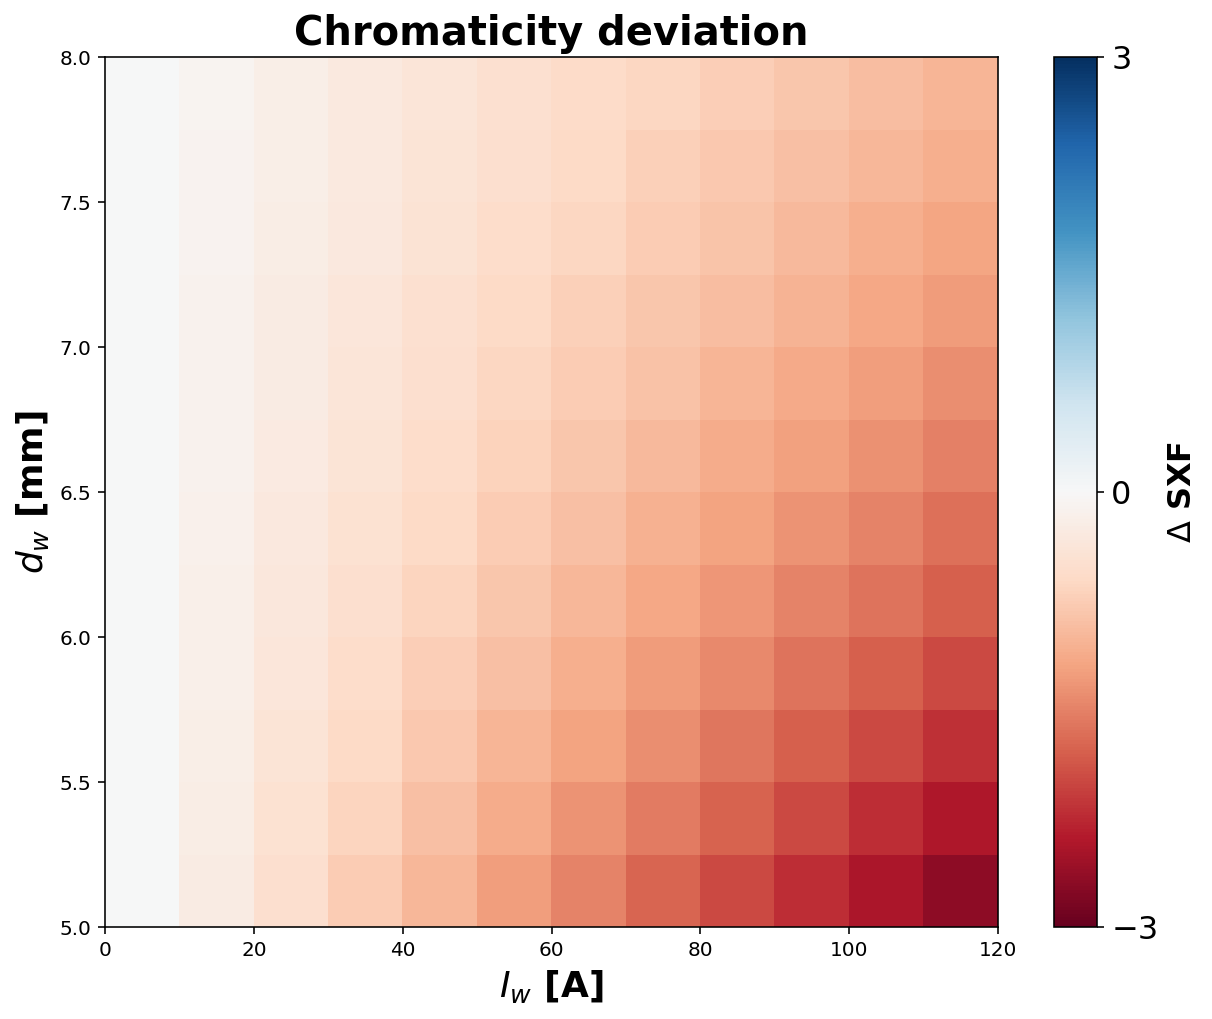

In [57]:
# SXF

SXF0 = SXF[0]
SXF_matrix = np.reshape(SXF,(len(IW),len(d))) - SXF0

xx,yy = np.meshgrid(IW,d)
zz =np.transpose(SXF_matrix)

fig = plt.figure("scan2", figsize=(10,8))
ax  = fig.add_subplot(111)
ax.set_title("Chromaticity deviation", fontsize=20, fontweight='bold')
ax.set_ylabel("$d_w$ [mm]", fontsize=18, fontweight='bold')
ax.set_xlabel("$I_w$ [A]", fontsize=18, fontweight='bold')
cf = plt.pcolormesh(xx,yy,zz, cmap=plt.cm.RdBu)
minDQ = -3
maxDQ = 3
plt.clim(minDQ, maxDQ)
cbar = plt.colorbar(cf, ticks=np.linspace(minDQ, maxDQ, 3))
cbar.set_label('$\\Delta$ SXF', rotation=90, fontsize=16, fontweight='bold')
cbar.ax.tick_params(labelsize=16)

print('######### SXF #########')
print('Max Delta = {}'.format(np.max(zz)))
print('Min Delta = {}'.format(np.min(zz)))
print('Mean Delta = {}'.format(np.mean(zz)))

######### SXD #########
Max Delta = 0.0
Min Delta = -0.21945485695
Mean Delta = -0.084332782839


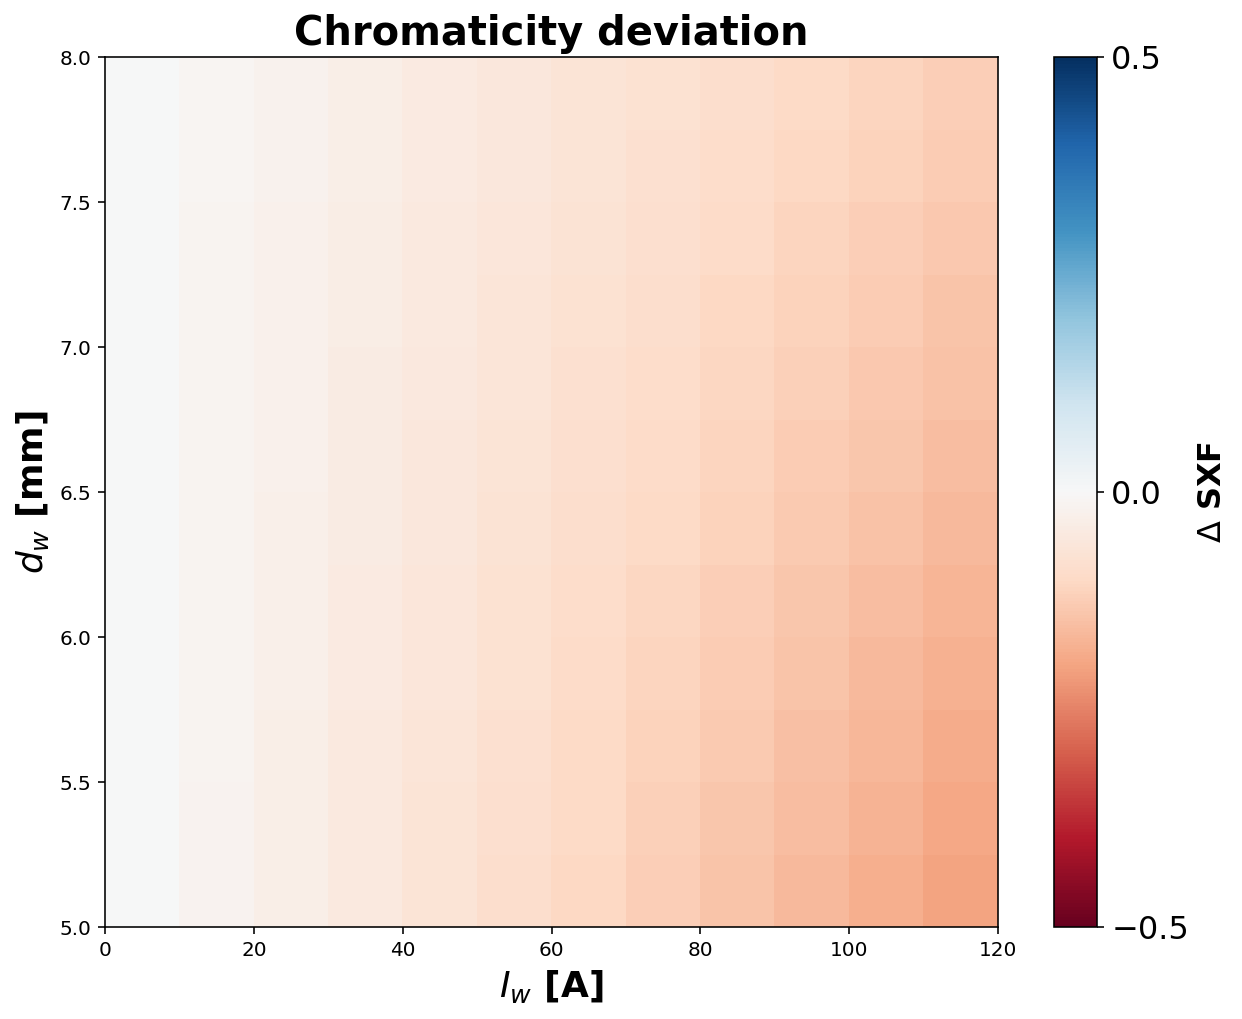

In [60]:
# SXD

SXD0 = SXD[0]
SXD_matrix = np.reshape(SXD,(len(IW),len(d))) - SXD0

xx,yy = np.meshgrid(IW,d)
zz =np.transpose(SXD_matrix)

fig = plt.figure("scan2", figsize=(10,8))
ax  = fig.add_subplot(111)
ax.set_title("Chromaticity deviation", fontsize=20, fontweight='bold')
ax.set_ylabel("$d_w$ [mm]", fontsize=18, fontweight='bold')
ax.set_xlabel("$I_w$ [A]", fontsize=18, fontweight='bold')
cf = plt.pcolormesh(xx,yy,zz, cmap=plt.cm.RdBu)
minDQ = -.5
maxDQ = .5
plt.clim(minDQ, maxDQ)
cbar = plt.colorbar(cf, ticks=np.linspace(minDQ, maxDQ, 3))
cbar.set_label('$\\Delta$ SXF', rotation=90, fontsize=16, fontweight='bold')
cbar.ax.tick_params(labelsize=16)

print('######### SXD #########')
print('Max Delta = {}'.format(np.max(zz)))
print('Min Delta = {}'.format(np.min(zz)))
print('Mean Delta = {}'.format(np.mean(zz)))